In [1]:
import tensorflow as tf
from flows import DistLSTM, NormalRW, DFlow, ResFlow, NVPFlow, LogNormal, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import flows
import math

np.random.seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# flows.floatX = 'float32'

In [3]:
# floatX = flows.floatX.

In [4]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [5]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [6]:
xs = data

In [7]:
n = data.shape[1]
s1_prior_d = LogNormal(1, mu=math.log(0.01), sigma=0.8)

with tf.variable_scope('s1_inference', initializer=tf.random_normal_initializer(stddev=0.05), dtype=floatX):
    mu = tf.get_variable('mu', shape=[1])
    sigma = tf.get_variable('sigma', shape=[1])
    s1_d = LogNormal(1, mu=mu, sigma=sigma)
    
s1 = s1_d.sample()
s1_prior = s1_prior_d.logdens(s1)

with tf.variable_scope('incr_inference', initializer=tf.random_normal_initializer(stddev=0.05), dtype=floatX):
    mu = tf.get_variable('mu', shape=[1])
    sigma = tf.get_variable('sigma', shape=[1])
    incr_d = LogNormal(1, mu=mu, sigma=sigma)
    
incr_prior_d = LogNormal(1, mu=math.log(.8), sigma=.5)
incr = incr_d.sample()
incr_prior = incr_prior_d.logdens(incr)

incr += 1
s_shock = s1*incr
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
#     ldiag.logdens -= tf.reduce_sum(ldiag.output)
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='OrdWalk', 
#                    ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk_shock = MVNormalRW(dim=dim[0]*dim[1], sigma0=s0, sigma=s_shock, name='ShockWalk', 
#                        ldiag=ldiag.output[0]+np.log(1/s1)-np.log(0.5))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1, name='OrdWalk')
PWalk_shock = NormalRW(dim=None, sigma0=s0, sigma=s_shock, name='ShockWalk')

In [61]:
ss = []
for _ in range(1000):
    n = sess.run([s1, s_shock])
    ss.append(n)
ss = np.array(ss)[:,:,0]

In [62]:
ss.mean(axis=0)

array([0.0178, 0.0221])

In [8]:
# sess = tf.InteractiveSession()
# tf.global_variables_initializer().run()

In [9]:
# s1.eval()

In [10]:
s1, incr

(<tf.Tensor 'LogNormal_1/Exp:0' shape=(1,) dtype=float64>,
 <tf.Tensor 'add:0' shape=(1,) dtype=float64>)

In [8]:
# a = tf.linalg.inv(PWalk.inverse_sigma)
# tf.summary.histogram('WALK',tf.sqrt(tf.diag(a)))

In [9]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [10]:
dim_ = dim[0]*dim[1]

init = Normal([1,n, dim_], sigma=0.01)
out_sample = init.sample()

flows_0 = [LinearChol(dim_, name='lc0_0', use_bias=False)(out_sample[:,0,:])]
for i in range(n-1):
    aux = flows_0[-1][-1].output
    new = LinearChol(dim_, name='lc0_{}'.format(i+1), aux_vars=aux, use_bias=False)(out_sample[:,i+1,:])
    flows_0.append(new)

In [11]:
flows = flows_0
outputs = [x[-1].output for x in flows_0]
outputs = tf.concat(outputs, axis=0)
outputs += tf.Variable(np.zeros([n,dim_], floatX))
outputs = tf.cumsum(outputs)[tf.newaxis]

In [12]:
# init_out = tf.stack([outputs[0,0]]*n)[tf.newaxis]

# outputs = tf.where(phase, outputs, init_out)

In [13]:
# init_out

In [14]:
outputs

<tf.Tensor 'strided_slice_20:0' shape=(1, 20, 12) dtype=float64>

In [15]:
prior_ord = PWalk.logdens(outputs, reduce=False)
prior_shock = PWalk_shock.logdens(outputs, reduce=False)

In [16]:
prior_ord, prior_shock

(<tf.Tensor 'OrdWalk_2/concat:0' shape=(1, 20) dtype=float64>,
 <tf.Tensor 'ShockWalk_2/concat:0' shape=(1, 20) dtype=float64>)

In [17]:
aux = tf.range(0,19, dtype=floatX)[tf.newaxis,:,tf.newaxis]
aux

<tf.Tensor 'strided_slice_21:0' shape=(1, 19, 1) dtype=float64>

In [18]:
# shock_d = DistLSTM(2, name='Shock_Distr', sample_len=20, aux_vars=aux, state_dim=32, num_layers=2)
with tf.variable_scope('Shock_Distr', dtype=floatX):
    logits = tf.get_variable('bern_logits', shape=[1,20,1], 
                             initializer=tf.random_normal_initializer(stddev=0.1, mean=-1.))
    shock_d = tf.distributions.Bernoulli(logits=logits)

In [19]:
shocks = shock_d.sample()
shock_prior = tf.contrib.distributions.Poisson(rate=4.)

In [20]:
num_shocks = tf.reduce_sum(tf.cast(shocks[:,:,0], tf.float32))
tf.summary.scalar('num_shocks', num_shocks)
# num_shocks = tf.Print(num_shocks, data=[num_shocks])
shock_prior = shock_prior.log_prob(num_shocks)
shock_prior = tf.cast(shock_prior, tf.float64)
tf.summary.scalar('shock_prior', shock_prior)
shock_prior

<tf.Tensor 'Cast_1:0' shape=() dtype=float64>

In [21]:
prior = tf.where(tf.cast(shocks[:,:,0], tf.bool), prior_shock, prior_ord)
print(prior)
prior = tf.reduce_sum(prior) + shock_prior
tf.summary.scalar('prior', prior)

Tensor("Select:0", shape=(1, 20), dtype=float64)


<tf.Tensor 'prior:0' shape=() dtype=string>

In [22]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=floatX)
    return obs_d.logdens(ar - xs[0][1:])

In [23]:
logl = create_loglik2()
tf.summary.scalar('logl', logl)

<tf.Tensor 'logl:0' shape=() dtype=string>

In [24]:
# df = dim[0]*dim[1]
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [25]:
# shock_d.log_prob(shocks)

In [26]:
shock_prob = tf.reduce_sum(shock_d.log_prob(shocks))
tf.summary.scalar('shock_ent', -shock_prob)

<tf.Tensor 'shock_ent:0' shape=() dtype=string>

In [27]:
ent = -tf.reduce_sum([flow[-1].logj for flow in flows]) + init.logdens(out_sample)
# ent = tf.where(phase, ent, -flows[0][-1].logj + init.logdens(out_sample[:,0]))

In [28]:
prior += incr_prior + s1_prior

In [29]:
KLd = -logl - prior + ent + shock_prob# - cov_prior.log_prob(PWalk.fsigma) + ldiag.logdens# + lowerd.logdens
KLd /= n*dim[0]*dim[1]

In [30]:
shock_vars = [x for x in tf.global_variables() if 'Shock_Distr' in x.name]
shock_vars

[<tf.Variable 'Shock_Distr/bern_logits:0' shape=(1, 20, 1) dtype=float64_ref>]

In [31]:
shock_reinforce = tf.gradients(shock_prob, shock_vars)
with tf.variable_scope('CV', dtype=floatX, initializer=tf.random_normal_initializer(stddev=0.1)):
#     shock_flat = tf.reshape(shocks, [1,20])
#     W = tf.get_variable('W1', shape=[20,80])
#     b = tf.get_variable('b1', shape=[1,80])
#     cv1 = tf.matmul(shock_flat, W) + b
#     cv1 = tf.nn.tanh(cv1)
#     W = tf.get_variable('W2', shape=[80,1])
#     b = tf.get_variable('b2', shape=[1,1])
#     cv2 = tf.matmul(cv1, W) + b
#     print(cv2)
#     cv2 = cv2[0,0]
#     cv = tf.get_variable('cv', shape=(1,))
#     controls = [cv]
    cv = tf.get_variable('cv', shape=(1,), trainable=False)
    cv_op = cv.assign(0.96*cv + 0.04*KLd)
# shock_reinforce = [x*KLd for x in shock_reinforce]
# shock_reinforce = [x*(KLd-cv) for x,cv in zip(shock_reinforce, controls)]
shock_reinforce = [x*(KLd-cv) for x in shock_reinforce]

In [32]:
cv_loss = [tf.reduce_mean(x*x) for x in shock_reinforce]
cv_loss = tf.reduce_mean(cv_loss)
tf.summary.scalar('cv_loss', cv_loss)
# cv_gradients = tf.gradients(cv_loss, controls)

<tf.Tensor 'cv_loss:0' shape=() dtype=string>

In [33]:
rest_vars = [x for x in tf.global_variables() if not ('CV' in x.name or 'Shock_distr' in x.name)]
rest_gradients = tf.gradients(KLd, rest_vars)

In [34]:
xs = shock_vars + rest_vars# + controls 
grads = shock_reinforce + rest_gradients# + cv_gradients 
updates = [(g,x) for x,g in zip(xs, grads)]

In [35]:
KLd

<tf.Tensor 'truediv:0' shape=() dtype=float64>

In [36]:
tf.summary.scalar('KLd', KLd)

<tf.Tensor 'KLd:0' shape=() dtype=string>

In [86]:
opt = tf.train.GradientDescentOptimizer(0.00003)

In [87]:
opt = [opt.apply_gradients(updates), cv_op]

In [39]:
sess = tf.InteractiveSession()

In [40]:
# !rm -R /tmp/tfdbg
!mkdir /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg/bern_more_shock')

mkdir: cannot create directory ‘/tmp/tfdbg’: File exists


In [41]:
writer.add_graph(tf.get_default_graph())

In [42]:
tf.global_variables_initializer().run()

In [43]:
prior.eval(), ent.eval(), logl.eval()

(-290.49099710776903, 752.6222483353395, -573.3942668960901)

In [44]:
KLd.eval()

6.874848303982191

In [45]:
np.set_printoptions(precision=4)

In [46]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [47]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [48]:
epoch = 0

In [49]:
all_sum = tf.summary.merge_all()

In [50]:
# for epoch in range(epoch, 20):
#     for i in range(800):
#         l, _ = sess.run([loss, opt], {phase:False})
#     print(l)

In [88]:
%%time
for epoch in range(epoch, epoch+10000):
    for i in range(1000):
        l, _ = sess.run([KLd, opt], {phase:True})
        if i % 10 == 0 and epoch > 2:
            s = all_sum.eval({phase:True})
            writer.add_summary(s, global_step=epoch*1000 + i)
    print(l)
#     print(PWalk.inverse_sigma.eval()[:3,:3])
#     print('\n')

0.346511623155523
0.35062010090145646
0.33332474466330525
0.3452963353117012
0.3421877425800545
0.33629204307404675
0.3431726893853761
0.3474079450738375
0.32547055806422814
0.3367681112183155
0.33300571722158495
0.35463372859049797
0.360721022435919
0.35107538237908853
0.33805346781320406
0.3295535394578409
0.3354444122324092
0.34478627666436024
0.3401748239768852
0.357727853675461
0.33856231081498744
0.34986625226981355
0.3442554946762908
0.3368265586831661
0.3417914911705711
0.34481304077019
0.3249570879626064
0.345578946873255
0.3777574872481838
0.34076241037172667
0.3618996344449038
0.34791202943488514
0.33452428601705125
0.3108025781591703
0.34753139736957056
0.343580493082247
0.3498406384971015
0.3323324668586521
0.33676271787674045
0.346832381864024
0.3361621944957021
0.356156230147999
0.3407316254906672
0.3494581099868094
0.35109874408968944
0.3556211206187417
0.3486480614118609
0.34531834294641683
0.35224934463759927
0.3330274797045212
0.35028406126925304
0.3279121754990822
0

KeyboardInterrupt: 

In [89]:
epoch

964

In [90]:
ss = []
for _ in range(40000):
    s = shocks.eval()[:,:,0].astype('float')
    ss.append(s)
ss = np.array(ss)
print(ss.mean(axis=0))

[[0.381  0.3352 0.3174 0.302  0.3115 0.3161 0.2987 0.3109 0.3131 0.3241
  0.3183 0.3275 0.3366 0.3258 0.3179 0.3145 0.3163 0.3249 0.3301 0.3176]]


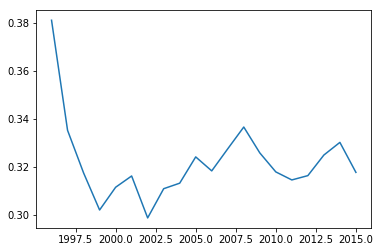

In [92]:
x = range(1996,2016)
plt.plot(x, ss.mean(axis=0)[0])
plt.show()

In [71]:
ss = []
aa = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
    aa.append(a)
ss = np.array(ss)
aa = np.array(aa)

AttributeError: 'NormalRW' object has no attribute 'inverse_sigma'

In [48]:
aa.mean(axis=0)[:5,:5]

array([[ 1.2923e-04, -7.1903e-09,  3.5436e-08,  6.2896e-08,  3.5567e-08],
       [-7.1903e-09,  1.3707e-04,  9.9602e-08, -8.9267e-08,  2.4762e-08],
       [ 3.5436e-08,  9.9602e-08,  1.2321e-04,  5.1597e-08,  7.2189e-08],
       [ 6.2896e-08, -8.9267e-08,  5.1597e-08,  1.2432e-04, -7.2140e-08],
       [ 3.5567e-08,  2.4762e-08,  7.2189e-08, -7.2140e-08,  1.3892e-04]])

In [49]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0112, 0.0115, 0.0109, 0.011 , 0.0116, 0.0112, 0.0116, 0.0117,
        0.0098, 0.0093, 0.01  , 0.011 ]),
 array([0.0018, 0.002 , 0.0019, 0.0019, 0.002 , 0.0018, 0.0019, 0.0019,
        0.0017, 0.0015, 0.0016, 0.0017]))

In [72]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [73]:
samples = []
for _ in range(3000):
    s = out.eval({phase:True})
    samples.append(s)
samples = np.array(samples)

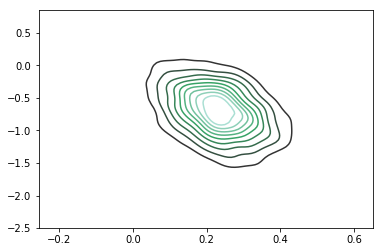

In [74]:
t = 10
sns.kdeplot(samples[:,t,2,0], samples[:,t,0,3])
plt.show()

In [75]:
t = 10
# params[t]

In [76]:
np.mean(samples[:,t], axis=0)

array([[-0.3068, -0.011 , -0.2015, -0.7039],
       [ 0.0662,  0.178 ,  0.5773,  0.5648],
       [ 0.2297, -0.0859,  0.8326,  1.005 ]])

In [43]:
np.mean(samples[:,t], axis=0)

array([[-0.1967, -0.0331, -0.0692, -0.8973],
       [ 0.0807,  0.1957,  0.629 ,  0.1535],
       [ 0.2592, -0.0342,  0.8069,  1.1076]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


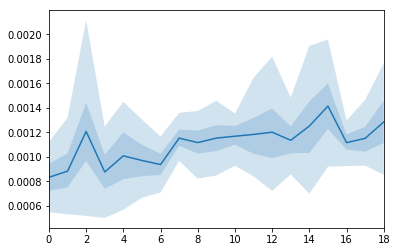

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


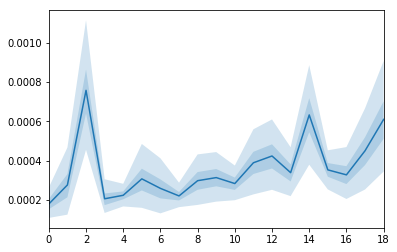

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


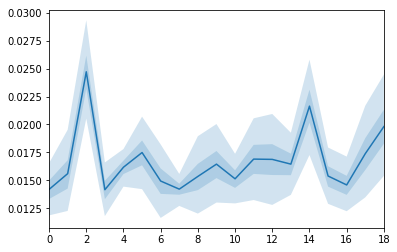

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()